In [1]:
# import nltk
# import subprocess

# # Download and unzip wordnet
# try:
#     nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

# # Now you can import the NLTK resources as usual
# from nltk.corpus import wordnet

In [2]:
# import nltk
# # nltk.download('stopwords')
# # nltk.download('wordnet')
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU found")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Sorry, no GPU found")

2025-01-12 00:10:56.393709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 00:10:56.393853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 00:10:56.471393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 00:10:56.631593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 00:10:58.474928: W tensorflow/compiler/tf2

GPU found


2025-01-12 00:11:01.560601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-12 00:11:01.909837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-12 00:11:01.909943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation,Dropout,SpatialDropout1D,Bidirectional,LSTM
from tensorflow.keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D,GlobalMaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models, layers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer
from nltk.tag import pos_tag
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
import pandas as pd
import re
from string import punctuation
from collections import Counter

# **Retrieving Dataset**

### Training Dataframe

In [4]:
# https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
df = pd.read_csv('twitter_training.csv')
df.head(3)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


Testing Dataframe

In [5]:
df_validation = pd.read_csv('twitter_validation.csv')
df.head(3)

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


There is an issue with the dataset, there are no column names. So, we will add the column names manually.

In [6]:
print(df.shape)
print(df_validation.shape)

(74681, 4)
(999, 4)


In [7]:
# Add column names (Tweet_id, entity, sentiment, tweet)
df.columns = ['id', 'entity', 'sentiment', 'tweet']
df_validation.columns = ['id', 'entity', 'sentiment', 'tweet']
df.head(3)

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...


# **Data Preprocessing**

### Perform missing values/duplicated data checking and cleaning

In [8]:
print(df.isna().sum())
print("Duplicated Data:",df.duplicated().sum())

id             0
entity         0
sentiment      0
tweet        686
dtype: int64
Duplicated Data: 2700


In [9]:
df = df.dropna()
df = df.drop_duplicates()
print(df.isna().sum())
print("Duplicated Data:",df.duplicated().sum())

id           0
entity       0
sentiment    0
tweet        0
dtype: int64
Duplicated Data: 0


In [10]:
# Mapping
df['sentiment'].value_counts()

sentiment
Negative      21698
Positive      19712
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

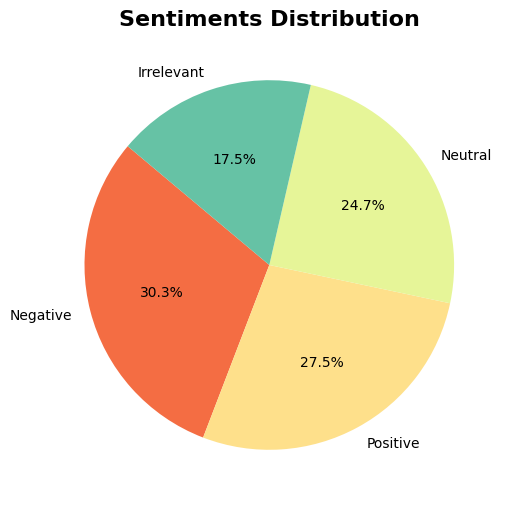

In [11]:
fig = plt.figure(figsize=(6, 6))
# Data for plotting
sizes = df['sentiment'].value_counts().values
labels = df['sentiment'].value_counts().keys()
colors = sns.color_palette('Spectral', len(labels))

# Create a pie chart
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
plt.title('Sentiments Distribution', fontsize=16, fontweight='bold')

plt.show()


The dataset is considered balanced

# **Text Preprocessing**

In [12]:
def preprocessing(tweet):
    # Lowercase
    tweet = tweet.lower()
    # URL
    tweet = re.sub(r'http\S+|www\S+|https\S+', ' ', tweet, flags=re.MULTILINE)
    # Emoji
    tweet = re.sub(r'[^\x00-\x7F]+', ' ', tweet)
    # Punctuation
    tweet = re.sub(r'[^a-zA-Z0-9\s]', ' ', tweet)
    # Numbers
    tweet = re.sub(r'\d+', ' ', tweet)
    # Excess whitespaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    # Word Normalization
    tweet = re.sub(r"won\'t", "would not", tweet)
    tweet = re.sub(r"im", "i am", tweet)
    tweet = re.sub(r"Im", "i am", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"don\'t", "do not", tweet)
    tweet = re.sub(r"shouldn\'t", "should not", tweet)
    tweet = re.sub(r"needn\'t", "need not", tweet)
    tweet = re.sub(r"hasn\'t", "has not", tweet)
    tweet = re.sub(r"haven\'t", "have not", tweet)
    tweet = re.sub(r"weren\'t", "were not", tweet)
    tweet = re.sub(r"mightn\'t", "might not", tweet)
    tweet = re.sub(r"didn\'t", "did not", tweet)
    tweet = re.sub(r"wasn\'t", "was not", tweet)
    tweet = re.sub(r"ain\'t", "am not", tweet)
    tweet = re.sub(r"aren\'t", "are not", tweet)
    tweet = re.sub(r"\'bout", "about", tweet)
    tweet = re.sub(r"\'til", "until", tweet)
    tweet = re.sub(r"\'till", "until", tweet)
    tweet = re.sub(r"\'cause", "because", tweet)
    tweet = re.sub(r"\'em", "them", tweet)
    tweet = re.sub(r"\'n", "and", tweet)
    tweet = re.sub(r"\'d've", "would have", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    tweet = re.sub(r'unk', ' ', tweet)
    return tweet

df['tweet'] = df['tweet'].apply(preprocessing)
df_validation['tweet'] = df_validation['tweet'].apply(preprocessing)

In [13]:
df.head(5)

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,i am coming to the borders and i will kill you...
1,2401,Borderlands,Positive,i am getting on borderlands and i will kill yo...
2,2401,Borderlands,Positive,i am coming on borderlands and i will murder y...
3,2401,Borderlands,Positive,i am getting on borderlands and i will murder ...
4,2401,Borderlands,Positive,i am getting into borderlands and i can murder...


### Lemmatization

In [14]:
wnl = WordNetLemmatizer()
all_stopwords = set(stopwords.words('english'))
all_stopwords = [w for w in all_stopwords if w not in ['no','not']]


def lemmatizing(tweet):
    words = tweet.split()
    lemmatized_words = [wnl.lemmatize(word) for word in words if word not in all_stopwords]
    return ' '.join(lemmatized_words)

In [15]:
df['tweet'] = df['tweet'].apply(lemmatizing)
df_validation['tweet'] = df_validation['tweet'].apply(lemmatizing)

In [16]:
df.head(5)

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,coming border kill
1,2401,Borderlands,Positive,getting borderland kill
2,2401,Borderlands,Positive,coming borderland murder
3,2401,Borderlands,Positive,getting borderland murder
4,2401,Borderlands,Positive,getting borderland murder


# **Exploratory Data Analysis (EDA)**

### **Most Frequent Words**

/tmp/ipykernel_2324/2800253447.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="coolwarm")


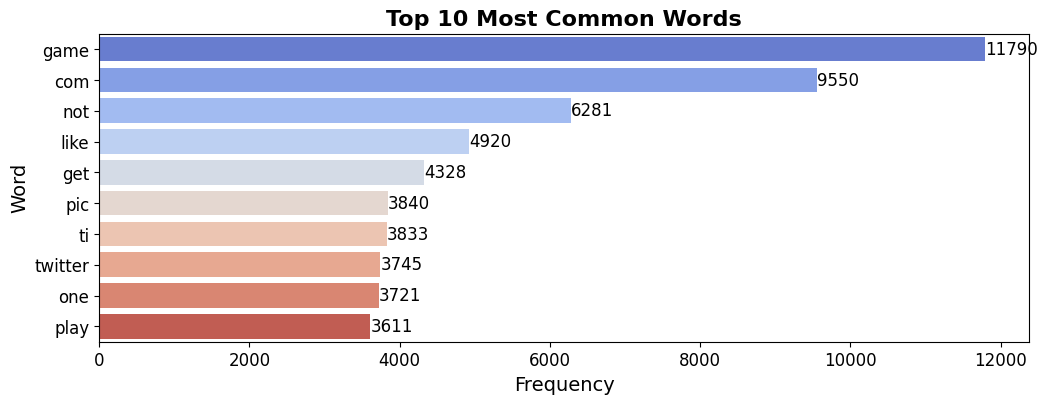

In [17]:
text = " ".join(df["tweet"])
tokens = text.split()

# Count the frequency of each word
word_counts = Counter(tokens)

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Separate the words and their counts
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

plt.figure(figsize=(12, 4))
sns.barplot(x=list(counts), y=list(words), palette="coolwarm")
plt.title("Top 10 Most Common Words", fontsize=16, fontweight='bold')
# Show the frequency in the bar
for i, count in enumerate(counts):
    plt.text(count, i, count, ha='left', va='center', fontsize=12)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Word", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### **Most frequent Positive, Negative, Neutral, and Irrelevant Sentiment data**

In [18]:
positive_words = df[df['sentiment'] == 'Positive']
positive_sentiment = positive_words['tweet']
negative_words = df[df['sentiment'] == 'Negative']
negative_sentiment = negative_words['tweet']
neutral_words = df[df['sentiment'] == 'Neutral']
neutral_sentiment = neutral_words['tweet']
irrelevant_words = df[df['sentiment'] == 'Irrelevant']
irrelevant_sentiment = irrelevant_words['tweet']

##### **Positive**

/tmp/ipykernel_2324/3999653214.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="Spectral") # green colors


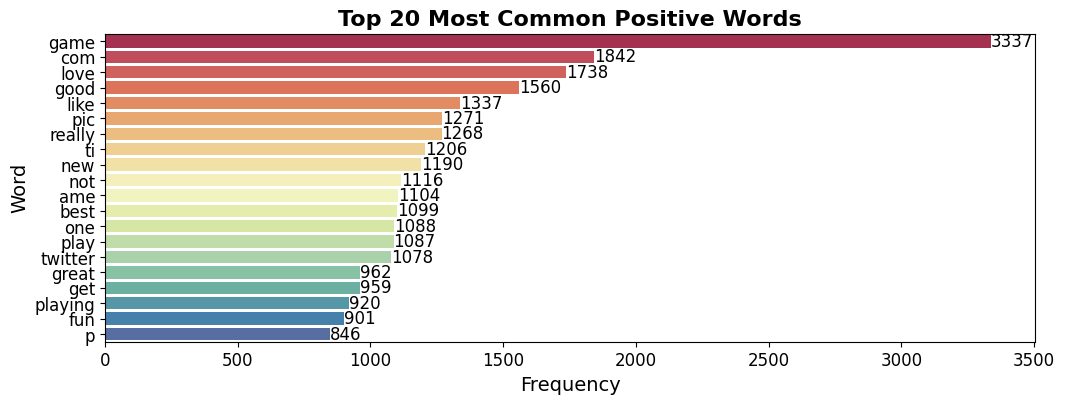

In [19]:
text = " ".join(positive_sentiment)
tokens = text.split()

word_counts = Counter(tokens)

top_words = word_counts.most_common(20)

words = [word for word, count in top_words]
counts = [count for word, count in top_words]

plt.figure(figsize=(12, 4))
sns.barplot(x=list(counts), y=list(words), palette="Spectral") # green colors
plt.title("Top 20 Most Common Positive Words", fontsize=16, fontweight='bold')

for i, count in enumerate(counts):
    plt.text(count, i, count, ha='left', va='center', fontsize=12)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Word", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##### **Negative**

/tmp/ipykernel_2324/4219671924.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="YlOrBr")


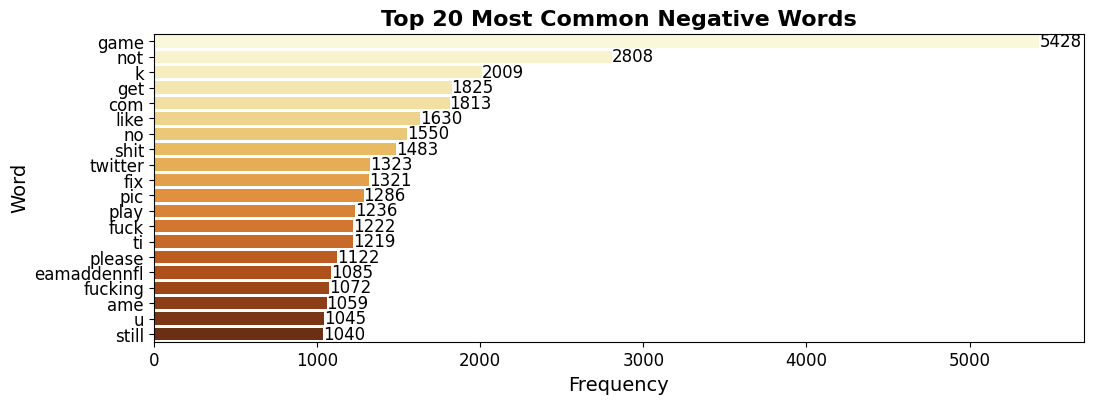

In [20]:
text = " ".join(negative_sentiment)
tokens = text.split()

word_counts = Counter(tokens)

top_words = word_counts.most_common(20)

words = [word for word, count in top_words]
counts = [count for word, count in top_words]

plt.figure(figsize=(12, 4))
sns.barplot(x=list(counts), y=list(words), palette="YlOrBr")
plt.title("Top 20 Most Common Negative Words", fontsize=16, fontweight='bold')

for i, count in enumerate(counts):
    plt.text(count, i, count, ha='left', va='center', fontsize=12)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Word", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##### **Neutral**

/tmp/ipykernel_2324/1989482092.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="magma")


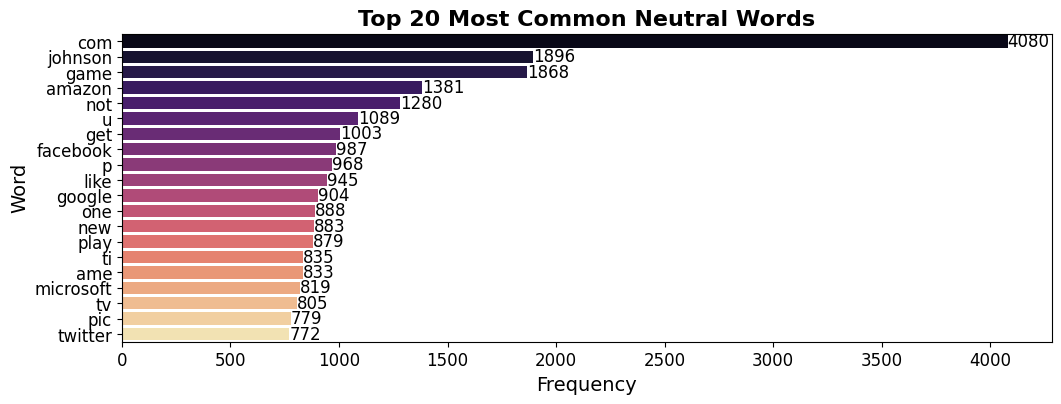

In [21]:
text = " ".join(neutral_sentiment)
tokens = text.split()

word_counts = Counter(tokens)

top_words = word_counts.most_common(20)

words = [word for word, count in top_words]
counts = [count for word, count in top_words]

plt.figure(figsize=(12, 4))
sns.barplot(x=list(counts), y=list(words), palette="magma")
plt.title("Top 20 Most Common Neutral Words", fontsize=16, fontweight='bold')
for i, count in enumerate(counts):
    plt.text(count, i, count, ha='left', va='center', fontsize=12)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Word", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [22]:
# Combine the lists (tweet_list, sentiment_list) into a DataFrame
df_training = df[['tweet', 'sentiment']].copy()
df_validation = df_validation[['tweet','sentiment']].copy()

Encode the sentiment

In [23]:
mappings = {
    'Negative': 0,
    'Neutral': 2,
    'Positive': 1
}

df_training = df_training[df_training['sentiment'] != 'Irrelevant']
df_validation = df_validation[df_validation['sentiment'] != 'Irrelevant']

df_training['sentiment'] = df_training['sentiment'].map(mappings)
df_validation['sentiment'] = df_validation['sentiment'].map(mappings)


In [24]:
tweet_list_train = df_training['tweet'].values
sentiment_list_train = df_training['sentiment'].values
tweet_list_val = df_validation['tweet'].values
sentiment_list_val = df_validation['sentiment'].values

### Fitting Tokenizer

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweet_list_train)

# Convert text data to sequences of integers
train_sequences = tokenizer.texts_to_sequences(tweet_list_train)
valid_sequences = tokenizer.texts_to_sequences(tweet_list_val)

maxlength = 100 # Maximum length of the sequences after padding

X = pad_sequences(train_sequences, maxlen=maxlength)
X_valid = pad_sequences(valid_sequences, maxlen=maxlength)

In [26]:
# Save the tokenizer file as pkl
with open('tokenizer.pkl', 'wb') as file:
    pkl.dump(tokenizer, file)

# **Model Training**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, sentiment_list_train, test_size=0.1, random_state=42)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_valid.shape)
print(sentiment_list_val.shape)

(53206, 100)
(53206,)
(5912, 100)
(5912,)
(828, 100)
(828,)


In [29]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

train_labels = np.array(y_train) 
test_labels = np.array(y_test)
sentiment_list_val = np.array(sentiment_list_val)

In [30]:
X_train.shape

(53206, 100)

In [31]:
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=200),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),  # BiLSTM without return_sequences, final output
    layers.Dropout(0.3), # Dropout is used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
    layers.Dense(32, activation='relu'),  # Additional Dense layer with ReLU
    layers.Dropout(0.3),  # Regular Dropout after Dense layer
    layers.Dense(3, activation='softmax')  # Output layer for 3 classes
])

opt = Adam(learning_rate = 0.005) # 0.001 0.0025 0,005 0.01

model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',  # Menggunakan sparse loss karena labelnya integer
    metrics=['accuracy']
)


2025-01-12 00:11:23.491060: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-12 00:11:23.491220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-12 00:11:23.491287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-12 00:11:23.887955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-12 00:11:23.888077: I external/local_xla/xla/stream_executor

In [32]:
history = model.fit(
    X_train, train_labels,
    validation_data=(X_valid, sentiment_list_val),
    epochs=30,
    batch_size=512,
    verbose=1
)

Epoch 1/30


2025-01-12 00:11:33.974345: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/kevin/anaconda3/envs/tf/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget
2025-01-12 00:11:34.853454: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4081361720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-12 00:11:34.853522: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-01-12 00:11:34.876973: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736615495.003750    2797 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/104 [==============================] - 27s 166ms/step - loss: 0.7146 - accuracy: 0.7003 - val_loss: 0.4282 - val_accuracy: 0.8611
Epoch 2/30
104/104 [==============================] - 14s 136ms/step - loss: 0.3663 - accuracy: 0.8627 - val_loss: 0.2249 - val_accuracy: 0.9215
Epoch 3/30
104/104 [==============================] - 13s 125ms/step - loss: 0.2441 - accuracy: 0.9047 - val_loss: 0.2735 - val_accuracy: 0.9275
Epoch 4/30
104/104 [==============================] - 12s 113ms/step - loss: 0.1918 - accuracy: 0.9234 - val_loss: 0.3059 - val_accuracy: 0.9227
Epoch 5/30
104/104 [==============================] - 11s 106ms/step - loss: 0.1602 - accuracy: 0.9336 - val_loss: 0.3202 - val_accuracy: 0.9239
Epoch 6/30
104/104 [==============================] - 11s 105ms/step - loss: 0.1367 - accuracy: 0.9429 - val_loss: 0.3616 - val_accuracy: 0.9275
Epoch 7/30
104/104 [==============================] - 11s 106ms/step - loss: 0.1235 - accuracy: 0.9476 - val_loss: 0.4027 - val_accuracy: 0.9

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [42]:
model.save('model.keras')

### Model Evaluation

In [35]:
test_loss, test_accuracy = model.evaluate(X_test,test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")

185/185 [==============================] - 5s 25ms/step - loss: 0.5648 - accuracy: 0.9065
Test Accuracy: 90.6461%


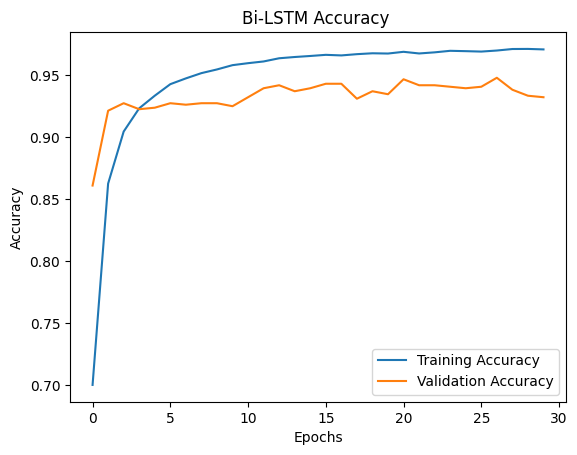

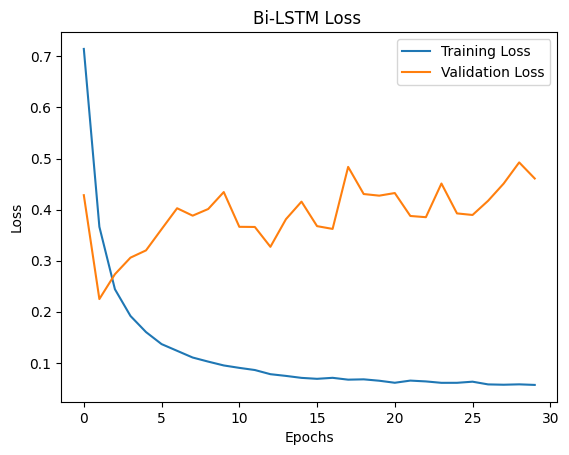

In [36]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Bi-LSTM Accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Bi-LSTM Loss ")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

##### Confusion Matrix for testing data

185/185 [==============================] - 5s 24ms/step


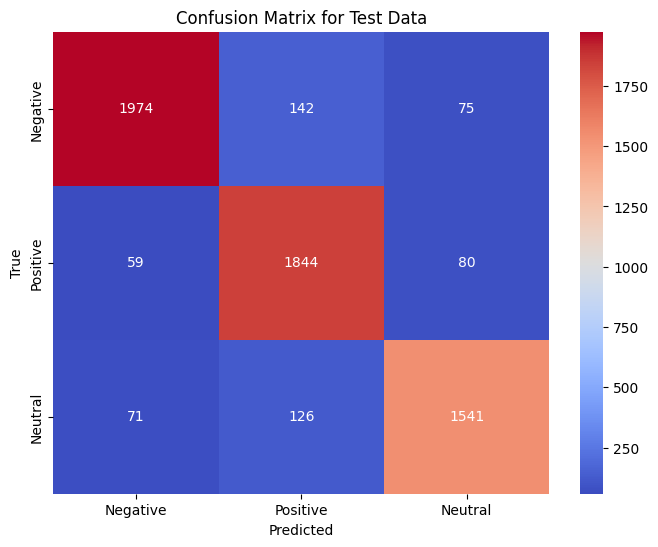

In [37]:
def prepare_labels(predictions, true_labels):
    pred_labels = predictions if len(predictions.shape) == 1 else np.argmax(predictions, axis=1)
    true_labels = true_labels if len(true_labels.shape) == 1 else np.argmax(true_labels, axis=1)
    return pred_labels, true_labels

def plot_confusion_matrix(conf_matrix, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {title} Data')
    plt.show()

# Prediction and label preparation
y_pred = model.predict(X_test)
y_pred_labels, y_true_labels = prepare_labels(y_pred, test_labels)

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
class_names = ['Negative', 'Positive', 'Neutral']  # Adjust class names as needed
plot_confusion_matrix(conf_matrix, class_names, 'Test')


##### Confusion Matrix for Validation Data

26/26 [==============================] - 1s 21ms/step


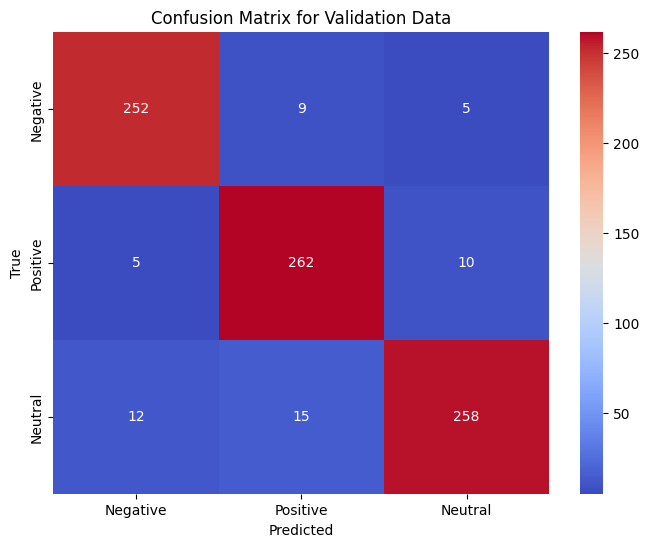

In [38]:
# Confusion matrix for validation data
y_pred_val = model.predict(X_valid)
y_pred_labels_val, y_true_labels_val = prepare_labels(y_pred_val, sentiment_list_val)

conf_matrix_val = confusion_matrix(y_true_labels_val, y_pred_labels_val)
plot_confusion_matrix(conf_matrix_val, class_names, 'Validation')
